In [1]:
import mysql.connector
import sshtunnel
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
host = 'vision.local'
localhost = '127.0.0.1'
ssh_username = 'rileyevans'
ssh_private_key = '~/.ssh/id_rsa'
user='crickettesting_django'
password='-N3gdCp-K7WN'
database='crickly-testing_django'
server = sshtunnel.SSHTunnelForwarder(
    (host, 22),
    ssh_username=ssh_username,
    ssh_private_key=ssh_private_key,
    remote_bind_address=('localhost', 3306)
)
server.start()

conn = mysql.connector.connect(host='localhost',
    port=server.local_bind_port,
    user=user,
    passwd=password,
    db=database
)

def query(q):
    return pd.read_sql_query(q, conn)
   

In [3]:
balls = query('''
select 
	bbb.over_number,
	bbb.ball_number,
	bbb.runs,
	is_wicket,
	total_runs,
	total_balls,
	total_wickets,
	total_batsman_balls,
	total_bat_runs total_batsman_runs,
	total_bowler_balls,
	total_bowl_runs total_bowler_runs,
	total_bowler_wickets,
	bat_s.average batsman_average,
	bat_s.average_last4 batsman_average_last4,
	bat_s.dismissal_rate batsman_dismissal_rate,
	bat_s.dismissal_rate_last4 batsman_dismissal_rate_last4,
	bowl_s.average bowler_average,
	bowl_s.average_last4 bowler_average_last4,
	bowl_s.dismissal_rate bowler_dismissal_rate,
	bowl_s.dismissal_rate_last4 bowler_dismissal_rate_last4
from 
	pcsp_bbb_ball bbb
	inner join match_sim_wicket_detection_batsmen_static bat_s on bbb.batsman_id = bat_s.player_id and bbb.match_id = bat_s.match_id
	inner join match_sim_wicket_detection_bowler_static bowl_s on bbb.bowler_id = bowl_s.player_id and bbb.match_id = bowl_s.match_id
order by bbb.id;
''')

In [4]:
balls = balls.dropna()

Now the data can be converted to a DMatrix for XGBoost

In [5]:
features = [
    'total_runs',
    'total_balls',
    'total_wickets',
    'total_batsman_balls',
    'total_batsman_runs',
    'total_bowler_balls',
    'total_bowler_runs',
    'total_bowler_wickets',
    'batsman_average',
    'batsman_average_last4',
    'batsman_dismissal_rate',
    'batsman_dismissal_rate_last4',
    'bowler_average',
    'bowler_average_last4',
    'bowler_dismissal_rate',
    'bowler_dismissal_rate_last4',
]

label = 'is_wicket'

In [12]:
train_x, test_x, train_y, test_y = train_test_split(balls[features], balls[label], stratify=balls[label])

In [15]:
train_set = xgb.DMatrix(train_x, label=train_y)
test_set = xgb.DMatrix(test_x, label=test_y)

In [89]:
param = {
    'max_depth': 2,
    'eta': 1, 
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
}
evallist = [(test_set, 'eval'), (train_set, 'train')]

In [46]:
num_round = 10
bst = xgb.train(param, train_set, num_round, evallist)

[0]	eval-error:0.02940	train-error:0.02948
[1]	eval-error:0.02940	train-error:0.02948
[2]	eval-error:0.03128	train-error:0.03143
[3]	eval-error:0.02936	train-error:0.02949
[4]	eval-error:0.02937	train-error:0.02952
[5]	eval-error:0.02864	train-error:0.02849
[6]	eval-error:0.02875	train-error:0.02856
[7]	eval-error:0.02858	train-error:0.02845
[8]	eval-error:0.02857	train-error:0.02845
[9]	eval-error:0.02857	train-error:0.02840


In [24]:
results = bst.predict(test_set)

In [29]:
np.savetxt('wicket-deciding.csv', results, delimiter=',')

In [32]:
test_x.to_csv('wicket-deciding-test-x.csv', index=False)
test_y.to_csv('wicket-deciding-test-y.csv', index=False)

## Class Imbalance
One problem we have here is that there are significantly more balls that are not wickets than are wickets. This means that our class labelling has an imbalance which is not ideal.

In [58]:
is_wicket_balls = balls[balls['is_wicket'] == 1]
not_wicket_balls = balls[balls['is_wicket'] != 1].sample(n=len(is_wicket_balls.index))
b_balls = is_wicket_balls.append(not_wicket_balls)

In [59]:
b_train_x, b_test_x, b_train_y, b_test_y = train_test_split(
    b_balls[features], b_balls[label], stratify=b_balls[label]
)

In [60]:
b_train_set = xgb.DMatrix(b_train_x, label=b_train_y)
b_test_set = xgb.DMatrix(b_test_x, label=b_test_y)

In [61]:
b_evallist = [(b_test_set, 'eval'), (b_train_set, 'train')]

In [90]:
num_round = 10
b_bst = xgb.train(param, train_set, num_round, b_evallist)

[0]	eval-error:0.47670	train-error:0.47530
[1]	eval-error:0.47670	train-error:0.47530
[2]	eval-error:0.44117	train-error:0.43851
[3]	eval-error:0.47503	train-error:0.47419
[4]	eval-error:0.47544	train-error:0.47460
[5]	eval-error:0.45413	train-error:0.45433
[6]	eval-error:0.45329	train-error:0.45315
[7]	eval-error:0.44472	train-error:0.44430
[8]	eval-error:0.44493	train-error:0.44381
[9]	eval-error:0.44410	train-error:0.44367


In [70]:
b_results = b_bst.predict(b_test_set)

In [71]:
np.savetxt('wicket-deciding-b.csv', b_results, delimiter=',')
b_test_x.to_csv('wicket-deciding-test-x-b.csv', index=False)
b_test_y.to_csv('wicket-deciding-test-y-b.csv', index=False)

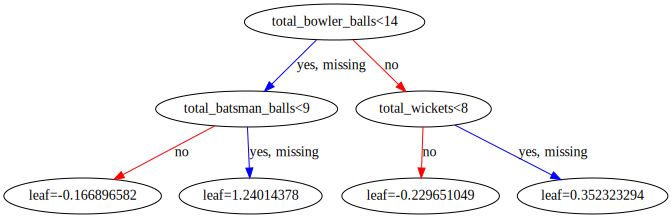

In [106]:
xgb.to_graphviz(b_bst, num_trees=5)

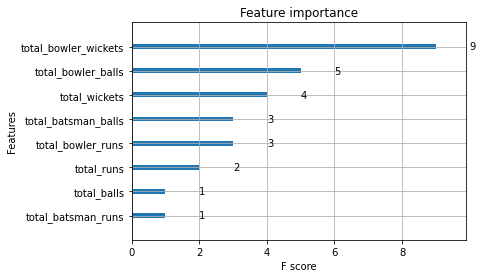

In [92]:
xgb.plot_importance(b_bst)

In [107]:
b_bst.save_model('b-wicket-decision.model')

In [108]:
bst.save_model('wicket-decision.model')